### OMP for SEM
Although we are predominantly focused on VAR models, let us consider briefly whether the OMP method is competitive for SEM models as well. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import OrthogonalMatchingPursuit

In [10]:
# generate SEM
import sys
sys.path.append("..")

from notears.notears.notears import linear
from notears.notears.notears import utils

import helper.helper as h
import helper.methods as m

from importlib import reload  # Python 3.4+

In [11]:
reload(h);
reload(m)
reload(linear)
reload(utils)

<module 'notears.notears.notears.utils' from '..\\notears\\notears\\notears\\utils.py'>

h: 9.413803070401627e-11.
rho: 1e+16.
loss: (2.1397350602528387, array([ 3.61166693e+01, -8.40791672e+01, -7.10572859e+01,  9.54924330e+01,
        5.65658916e+01,  1.30801725e-03,  3.36195777e+01,  2.54548124e-03,
        2.52314409e-03,  2.90813403e-03,  4.11226392e-03,  4.69730949e+01,
        3.84697766e+01, -4.89686401e+01, -3.12095744e+01, -8.04134061e-04,
        1.52130928e+01, -9.67436788e-04,  4.01622681e+01, -2.34235516e-03,
       -2.08257666e-03, -4.92494822e+01, -4.11052818e-03,  4.76485017e+01,
        3.78040266e+01, -3.61166693e+01,  8.40791672e+01,  7.10572859e+01,
       -9.54924330e+01, -5.65658916e+01, -1.30801725e-03, -3.36195777e+01,
       -2.54548124e-03, -2.52314409e-03, -2.90813403e-03, -4.11226392e-03,
       -4.69730949e+01, -3.84697766e+01,  4.89686401e+01,  3.12095744e+01,
        8.04134061e-04, -1.52130928e+01,  9.67436788e-04, -4.01622681e+01,
        2.34235516e-03,  2.08257666e-03,  4.92494822e+01,  4.11052818e-03,
       -4.76485017e+01, -3.78040266

TypeError: loop of ufunc does not support argument 0 of type numpy.ndarray which has no callable rint method

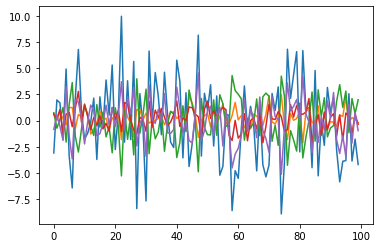

In [14]:
# set random seed
utils.set_random_seed(1)

n, d, s0, graph_type, sem_type = 100, 5, 5, 'ER', 'gauss'
B_true = utils.simulate_dag(d, s0, graph_type)
W_true = utils.simulate_parameter(B_true, w_ranges = ((-2.0, -0.5), (0.5, 2.0)))
    
X = utils.simulate_linear_sem(W_true, n, sem_type)

W_est = linear.notears_linear(X, lambda1=0.0, loss_type='l2', w_threshold = 0.01, h_tol = 1e-16)

# plot X
plt.plot(X);

# print W
print(f"True W:\n{np.round(W_true, 2)}.\n")
print(W_est)
print(f"NOTEARS W:\n{np.round(W_est, 2)}.\n")

# acc = utils.count_accuracy(B_true, W_est != 0)
print(acc)

In [13]:
T = n
    n = d

In [17]:
## Transform data
X = np.array(X)

print(np.shape(X.T))
# Blockwise repeat of X
X_large = np.kron(np.eye(n, dtype=float), X)

X_DAG = X_large.copy()

# Stack all X on top of each other for y
y_large = (X.T).reshape(T * n, 1)

# scores to remember
edges, scores, mses = [], [], []

# how verbose we want the output to be
verbose = False

# old W
omp_coefs_old = np.zeros(n ** 2)

viols = 0

for i in range(1, n ** 2 + 1):
    
    # fit OMP for i coefficients
    omp = OrthogonalMatchingPursuit(n_nonzero_coefs = i - viols)
    omp_fit = omp.fit(X_DAG, y_large)
    
    # get index of newly added edge
    omp_coefs_new = omp_fit.coef_.copy()
    
    # find the violating weight
    omp_coefs_diff = omp_coefs_new.copy()
    omp_coefs_diff[omp_coefs_old != 0] = 0
    
    print(omp_coefs_diff)
    edge_loc = np.array(np.where(omp_coefs_diff != 0))[0][0]
    
    # we check if we have violated the DAG constraint
    if not h.is_dag(omp_fit.coef_.reshape(n, n).T):
        ## option 1: We terminate the procedure
        print(f"Edge ({edge_loc % n + 1}, {edge_loc // n + 1}) added. violation! Removed.")
        # break
        
        ## option 2: We force this edge out, and continue
        # we force the edge out by setting the corresponding data to zero
        # this makes it by default the least desirable option
        # the data that corresponds to this coefficient is 
        to_remove = (edge_loc // n)  * n + edge_loc % n
        X_DAG[:, to_remove] = np.zeros((T - 1) * n)
    
        # increase number of violations, i - viols = number of coefs
        viols += 1
        
        # edge case: if violation at last iteration, we need to refit
        if i == n ** 2:
            # fit OMP for i coefficients
            omp = OrthogonalMatchingPursuit(n_nonzero_coefs = i - viols)
            omp_fit = omp.fit(X_DAG, y_large)
                
        continue
    else:
        edges.append((edge_loc % n + 1, edge_loc // n + 1))
        if i == 1:
            print(f"Edge ({edge_loc % n + 1}, {edge_loc // n + 1}) added w/ coef {round(omp_coefs_new[edge_loc], 2)}. Increased score by {round(omp.score(X_large, y_large), 2)}.")
        else:
            print(f"Edge ({edge_loc % n + 1}, {edge_loc // n + 1}) added w/ coef {round(omp_coefs_new[edge_loc], 2)}. Increased score by {round(omp.score(X_large, y_large) - scores[-1], 2)}.")
        
        
    # get results
    if verbose:
        print(np.round(omp_fit.coef_.reshape(n, n).T, 2))
        print(round(omp.score(X_large, y_large), 2))
        print(end="\n")
    
    # append results
    scores.append(omp.score(X_large, y_large))
    
    mses.append(h.MSE(omp_fit.coef_.reshape(n, n).T, X))
    
    # update coefficients
    omp_coefs_old = omp_coefs_new

W = np.round(omp_fit.coef_.reshape(n, n).T, 2)

plt.plot(range(1, len(mses) + 1), mses)
plt.vlines(s, min(mses), max(mses), linestyle = '--')
plt.xlabel("Number of edges.")
plt.ylabel("MSE.")
plt.show()

mses_diff = [a_i - b_i for a_i, b_i in zip(mses[1:], mses[:-1])]
plt.plot(range(1, len(mses_diff) + 1), mses_diff)
plt.vlines(s, min(mses_diff), max(mses_diff), linestyle = '--')
plt.xlabel("Number of edges.")
plt.ylabel("Change in mse")
plt.show()

plt.plot(range(1, len(scores) + 1), scores)
plt.vlines(s, min(scores), max(scores), linestyle = '--')
plt.xlabel("Number of edges.")
plt.ylabel("Score (R^2).")
plt.show()

scores_diff = [a_i - b_i for a_i, b_i in zip(scores[1:], scores[:-1])]
plt.plot(range(1, len(scores_diff) + 1), scores_diff)
plt.vlines(s, min(scores_diff), max(scores_diff), linestyle = '--')
plt.xlabel("Number of edges.")
plt.ylabel("Change in score (R^2)")
plt.show()

(5, 100)


ValueError: cannot reshape array of size 500 into shape (25,1)

In [15]:
T = n
n = d

In [16]:
## Transform data
X = np.array(X)

# Blockwise repeat of X
X_large = np.kron(np.eye(n, dtype=float), X)

# Stack all X on top of each other for y
y_large = (X.T).reshape(T * n, 1)

# make sure that we cannot pick the element itself
for i in range(n):
    X_large[:, i * (n + 1)] = np.zeros(T * n)
    
omp = OrthogonalMatchingPursuit(n_nonzero_coefs = 25)
omp_fit = omp.fit(X_large, y_large)

print(omp_fit.coef_)

ValueError: cannot reshape array of size 500 into shape (25,1)

In [ ]:
# old W
omp_coefs_old = np.zeros(n ** 2)

viols = 0

# scores to remember
edges, scores, mses = [], [], []

for i in range(1, int(n ** 2 + 1)):
    
    # fit OMP for i coefficients
    omp = OrthogonalMatchingPursuit(n_nonzero_coefs = i - viols)
    omp_fit = omp.fit(X_large, y_large)
    
    print(i - viols)
    
    # get index of newly added edge
    omp_coefs_new = omp_fit.coef_.copy()
    
    # find the violating weight
    omp_coefs_diff = omp_coefs_new.copy()
    omp_coefs_diff[omp_coefs_old != 0] = 0
    
    # check if the "fitted coefficient" is zero
    if len(omp_coefs_diff[omp_coefs_diff != 0]) == 0:
        continue
    else:
        edge_loc = np.array(np.where(omp_coefs_diff != 0))[0][0]
    
        # we check if we have violated the DAG constraint
        if not h.is_dag(omp_fit.coef_.reshape(n, n).T):
            ## option 1: We terminate the procedure
            print(f"Edge ({edge_loc % n + 1}, {edge_loc // n + 1}) added. violation! Removed.")
            # break
        
            ## option 2: We force this edge out, and continue
            # we force the edge out by setting the corresponding data to zero
            # this makes it by default the least desirable option
            # the data that corresponds to this coefficient is 
            to_remove = (edge_loc // n)  * n + edge_loc % n
            X_large[:, to_remove] = np.zeros(T * n)
    
            # increase number of violations, i - viols = number of coefs
            viols += 1
        
            # edge case: if violation at last iteration, we need to refit
            if i == n ** 2:
                # fit OMP for i coefficients
                omp = OrthogonalMatchingPursuit(n_nonzero_coefs = i - viols)
                omp_fit = omp.fit(X_DAG, y_large)
                
            continue
        else:
            edges.append((edge_loc % n + 1, edge_loc // n + 1))
            if i == 1:
                print(f"Edge ({edge_loc % n + 1}, {edge_loc // n + 1}) added w/ coef {round(omp_coefs_new[edge_loc], 2)}. Increased score by {round(omp.score(X_large, y_large), 2)}.")
            else:
                print(f"Edge ({edge_loc % n + 1}, {edge_loc // n + 1}) added w/ coef {round(omp_coefs_new[edge_loc], 2)}. Increased score by {round(omp.score(X_large, y_large) - scores[-1], 2)}.")
        
        
        # get results
        if verbose:
            print(np.round(omp_fit.coef_.reshape(n, n).T, 2))
            print(round(omp.score(X_large, y_large), 2))
            print(end="\n")
    
        # append results
        scores.append(omp.score(X_large, y_large))
    
        mses.append(h.MSE(omp_fit.coef_.reshape(n, n).T, X, is_sem = True))
    
        # update coefficients
        omp_coefs_old = omp_coefs_new

W = np.round(omp_fit.coef_.reshape(n, n).T, 2)

In [ ]:
# print W
print(f"True W:\n{np.round(W_true, 2)}.\n")
print(f"NOTEARS W:\n{np.round(W_est, 2)}.\n")
print(W)
print(h.is_dag(W))

In [168]:
print(h.score(X, W, W_true, is_sem = True));

True Positive Rate: 1.0.
True Negative Rate: 0.875.
False Prediction Rate: 0.2
Accuracy: 0.917.
R-Squared: 0.974
Mean Squared Error: 5.982
(1.0, 0.875, 0.2, 0.9166666666666666, 5.98233752822091, 0.9739572082247449)


In [166]:
print(h.score(X, W_est, W_true, is_sem = True));

True Positive Rate: 1.0.
True Negative Rate: 0.875.
False Prediction Rate: 0.2
Accuracy: 0.917.
R-Squared: 0.974
Mean Squared Error: 5.982
(1.0, 0.875, 0.2, 0.9166666666666666, 5.98178900120427, 0.9739581809269232)


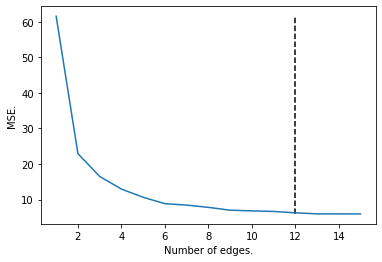

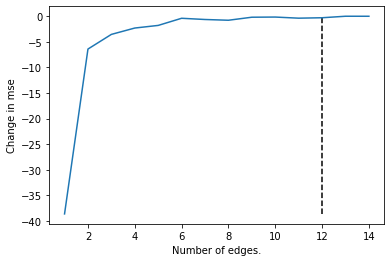

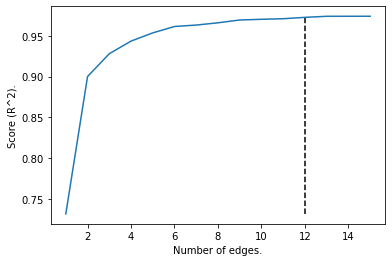

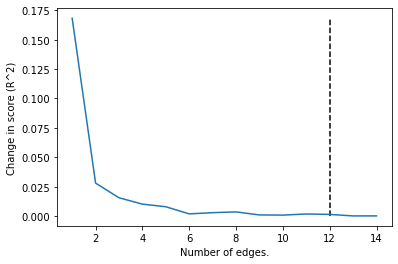

In [171]:
plt.plot(range(1, len(mses) + 1), mses)
plt.vlines(s0, min(mses), max(mses), linestyle = '--')
plt.xlabel("Number of edges.")
plt.ylabel("MSE.")
plt.show()

mses_diff = [a_i - b_i for a_i, b_i in zip(mses[1:], mses[:-1])]
plt.plot(range(1, len(mses_diff) + 1), mses_diff)
plt.vlines(s0, min(mses_diff), max(mses_diff), linestyle = '--')
plt.xlabel("Number of edges.")
plt.ylabel("Change in mse")
plt.show()

plt.plot(range(1, len(scores) + 1), scores)
plt.vlines(s0, min(scores), max(scores), linestyle = '--')
plt.xlabel("Number of edges.")
plt.ylabel("Score (R^2).")
plt.show()

scores_diff = [a_i - b_i for a_i, b_i in zip(scores[1:], scores[:-1])]
plt.plot(range(1, len(scores_diff) + 1), scores_diff)
plt.vlines(s0, min(scores_diff), max(scores_diff), linestyle = '--')
plt.xlabel("Number of edges.")
plt.ylabel("Change in score (R^2)")
plt.show()